In this notebook, we try to answer the question: with an optimized discriminator, does the Rabi amplitude change with and without DRAG correction?

### References

[1]: Li, Z., Liu, P., Zhao, P. *et al.* Error per single-qubit gate below 10−4 in a superconducting qubit. *npj Quantum Inf* **9**, 111 (2023). [https://doi.org/10.1038/s41534-023-00781-x](https://doi.org/10.1038/s41534-023-00781-x).

[2]: Z. Chen *et al.* Measuring and Suppressing Quantum State Leakage in a Superconducting Qubit. *Phys. Rev. Lett.* **116**, 020501 (2016) [https://doi.org/10.1103/PhysRevLett.116.020501](https://doi.org/10.1103/PhysRevLett.116.020501). 

## Dependencies

In [22]:
%config InlineBackend.figure_formats = ['svg']

import os
os.chdir('/Users/ngdnhtien/Codespace/PulsatingPulseShop/')

# qiskit
from qiskit import pulse
from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit, Gate
from qiskit_ibm_provider import IBMProvider

# qutritium
from utility import *
from constant import *

# numerical
import numpy as np
from scipy.optimize import curve_fit
import pickle 

# plot
from matplotlib.ticker import MultipleLocator

plt.rcParams['axes.linewidth'] = 1.25

In [23]:
provider = IBMProvider()
print(provider.backends())

backend = provider.get_backend('ibm_brisbane')

backend_config = backend.configuration()
backend_defaults = backend.defaults()
backend_properties = backend.properties()
dt = backend_config.dt

qubit = 109
cbit = 0
num_qubits = int(qubit+1)
num_cbits = 1
weight = 1

qubit_01_freq = backend_defaults.qubit_freq_est[qubit]
qubit_anharmonicty = backend_properties.qubits[qubit][3].value*GHz
qubit_12_freq = qubit_01_freq + qubit_anharmonicty

[<IBMBackend('simulator_statevector')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_osaka')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_mps')>]


In [24]:
p12_amp = 0.2234824425369455 # 6th Dec 2023

with pulse.build(backend=backend) as hp12_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Drag(duration=96, amp=p12_amp/2, sigma=24, beta=-0.5, name='hp12'), drive_chan)
    
hp12_gate = Gate(r'X_{\pi/2}^{(12)}', weight, [])
    
with pulse.build(backend=backend) as p12_sched:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Drag(duration=96, amp=p12_amp, sigma=24, beta=-0.5, name='p12'), drive_chan)

p12_gate = Gate(r'X_{\pi}^{(12)}', weight, [])

In [25]:
with pulse.build(backend=backend) as delay_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.delay(10000, drive_chan)
    
delay_gate = Gate('Delay for 5us', weight, [])

### Discriminator circs

In [31]:
ground_circ = QuantumCircuit(num_qubits, num_cbits)
ground_circ.append(delay_gate, [qubit])
ground_circ.measure(qubit, cbit)
ground_circ.add_calibration(delay_gate, [qubit], delay_sched)

first_excited_state_circ = QuantumCircuit(num_qubits, num_cbits)
first_excited_state_circ.append(delay_gate, [qubit])
first_excited_state_circ.x(qubit)
first_excited_state_circ.measure(qubit, cbit)
first_excited_state_circ.add_calibration(delay_gate, [qubit], delay_sched)


second_excited_state_circ = QuantumCircuit(num_qubits, num_cbits)
second_excited_state_circ.append(delay_gate, [qubit])
second_excited_state_circ.x(qubit)
second_excited_state_circ.append(p12_gate, [qubit])
second_excited_state_circ.measure(qubit, cbit)
second_excited_state_circ.add_calibration(delay_gate, [qubit], delay_sched)
second_excited_state_circ.add_calibration(p12_gate, [qubit], p12_sched)

discrim_circs = qiskit.transpile([ground_circ, first_excited_state_circ, second_excited_state_circ], backend=backend)

## Amplitude w/o DRAG

In [32]:
amps = np.linspace(-1, 1, 100)

rabi_circs_wDRAG = []

rabi12_gate = Gate(r'Rabi Gate', weight, [])

for amp in amps:
    
    with pulse.build(backend=backend) as rabi12_sched:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(qubit_12_freq, drive_chan)
        pulse.play(pulse.Drag(duration=96, amp=amp, sigma=24, beta=-0.5), drive_chan)

    rabi12_circ = QuantumCircuit(num_qubits, num_cbits)
    rabi12_circ.append(delay_gate, [qubit])
    rabi12_circ.x(qubit)
    rabi12_circ.append(rabi12_gate, [qubit])
    rabi12_circ.measure(qubit, cbit)
    rabi12_circ.add_calibration(delay_gate, [qubit], delay_sched)
    rabi12_circ.add_calibration(rabi12_gate, [qubit], rabi12_sched)
                   
    rabi_circs_wDRAG.append(rabi12_circ)
    
rabi_circs_wDRAG = qiskit.transpile(rabi_circs_wDRAG, backend=backend)

In [33]:
package = discrim_circs + rabi_circs_wDRAG

In [34]:
ampvdrag_job = backend.run(package, meas_level=1, meas_return='single', shots=2048)

In [29]:
ampvdrag_job = provider.backend.retrieve_job('cnt51mevn4c0008a37n0')

In [35]:
ampvdrag_data = DataAnalysis(experiment=ampvdrag_job, average=False, shots=2048, qubit=0)
ampvdrag_data.retrieve_data(average=False)
ampvdrag_data.build_discrim()
ampvdrag_data.count_pop()
ampvdrag_data.error_mitiq()

In [36]:
ampvdrag_data.score_012

0.9075520833333334

In [38]:
state0_withDRAG = ampvdrag_data.mitiq_data[int(3):int(3+100), 0]
state1_withDRAG = ampvdrag_data.mitiq_data[int(3):int(3+100), 1]
state2_withDRAG = ampvdrag_data.mitiq_data[int(3):int(3+100), 2]

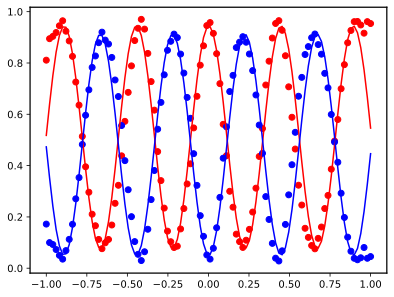

In [42]:
plt.scatter(amps, state1_withDRAG, color='red')
plt.scatter(amps, state2_withDRAG, color='blue')

ampvdrag_params_1, ampvdrag_fit_1 = fit_function(amps, state1_withDRAG, 
                    lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                    [1.0, 0, 0.4, 0])

ampvdrag_params_2, ampvdrag_fit_2 = fit_function(amps, state2_withDRAG, 
                    lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                    [1.0, 0, 0.4, 0])

plt.plot(amps, ampvdrag_fit_1, color='red')
plt.plot(amps, ampvdrag_fit_2, color='blue')

In [43]:
ampvdrag_params_1[2]/2, ampvdrag_params_2[2]/2

(0.2229952828398441, 0.22301462675707312)

In [44]:
new_amp = (ampvdrag_params_1[2]/2 + ampvdrag_params_2[2]/2)*0.5

new_amp

0.2230049547984586